<a href="https://colab.research.google.com/github/saugatabose28/Browser/blob/master/bertBILstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
"""
 """

!pip install transformers==3.0.0
!pip install emoji
import gc
#import os
import emoji as emoji
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoModel
from transformers import BertModel, BertTokenizer
!pip install scikit-plot
!pip install plot-metric
data_path="drive/My Drive/Colab Notebooks"
from google.colab import drive
drive.mount('/content/drive')

import torch.nn.functional as F

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #self.bert = BertModel.from_pretrained('bert-large-uncased')
        self.lstm = nn.LSTM(768, 128,2,batch_first=True,bidirectional=True)
        #self.lstm = nn.LSTM(1024, 128, batch_first=True,bidirectional=True)
        #self.linear = nn.Linear(145*2, 2)
        #self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
        self.fc = nn.Linear(128*2, 2) 
        #self.flat = nn.Flatten()
        #self.sigmoid = nn.Sigmoid()
    def forward(self, ids, mask):
          sequence_output, pooled_output = self.bert(ids,attention_mask=mask)
          #pooled_output=self.dropout(pooled_output)

          # sequence_output has the following shape: (batch_size, sequence_length, 768)
          lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
          hidden = torch.cat((lstm_output[:,-1, :128],lstm_output[:,0, 128:]),dim=-1)
          #linear_output = self.linear(hidden.view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification
          linear_output_ = self.fc(hidden.view(-1,128*2))
          #linear_output__= self.flat(linear_output_)
          linear_output=F.log_softmax(linear_output_, dim=1)
          return linear_output_,linear_output,sequence_output,lstm_output,pooled_output

def read_dataset():
    data = pd.read_csv(f"{data_path}/preProcessedBalancedSem2501.csv")
    #data = data.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
    #data = data.loc[0:9599,:]
    print(len(data))
    return data['tweet'].tolist(), data['class']


def pre_process_dataset(values):
    new_values = list()
    # Emoticons
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

    for value in values:
        # Remove dots
        print(value)
        text = value.replace(".", "").lower()
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url >")
        for emo in text:
            if emo in emoji.UNICODE_EMOJI:
                text = text.replace(emo, "<emoticon >")
        for emo in emoticons:
            text = text.replace(emo, "<emoticon >")
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number >")
        text = text.replace('#', "<hashtag >")
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text)
        new_values.append(text)
    return new_values


def data_process(data, labels):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=17,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    #del bert_tokenizer
    #gc.collect()
    #torch.cuda.empty_cache()
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    d=np.array(data)
    return input_ids, attention_masks, labels,d


def load_and_process():
    data, labels = read_dataset()
    num_of_labels = len(labels.unique())
    #input_ids, attention_masks, labels = data_process(pre_process_dataset(data), labels)
    input_ids, attention_masks, labels,d = data_process(data, labels)

    return input_ids, attention_masks, labels,d


# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        #print("batch size")
        #print(batch.shape)
        print(sent_id.shape)
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        #sent_id = torch.tensor(sent_id).to(device).long()
        y,preds,s,l,p = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss += float(loss.item())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        #preds = preds.detach().cpu().numpy()

        # append the model predictions
        #total_preds.append(preds)
        total_preds.append(preds.detach().cpu().numpy())


   
    gc.collect()
    torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds,y,s,l,p


# function for evaluating the model
def evaluate():
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):
        
        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            y,preds,s,l,p = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            #total_preds.append(preds)
            total_preds.append(preds.detach().cpu().numpy())

    
    gc.collect()
    torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds,y,s,l,p

# Specify the GPU
# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Load Data-set ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
input_ids, attention_masks, labels,text = load_and_process()
df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ class distribution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
# ~~~~~~~~~~ Split train data-set into train, validation and test sets  ~~~~~~~~~~#
#train_text, temp_text, train_labels, temp_labels = train_test_split(df, labels,
#                            random_state=2018, test_size=0.2, stratify=labels)

#val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
#                         random_state=2018, test_size=0.2, stratify=temp_labels)

temp_text, test_text, temp_labels, test_labels = train_test_split(df, labels,
                             random_state=2018, test_size=0.2, stratify=labels)

train_text, val_text, train_labels, val_labels = train_test_split(temp_text, temp_labels,
                         random_state=2018, test_size=0.2, stratify=temp_labels)

#with open(data_path, )
a=[]
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
for ids in test_text["input_ids"]:
  a.append(tokenizer.decode(ids))
d=pd.DataFrame(a)
d.to_csv(f"{data_path}/testSemBB.csv")



del temp_text
gc.collect()
torch.cuda.empty_cache()

train_count = len(train_labels)
test_count = len(test_labels)
val_count = len(val_labels)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~ Import BERT Model and BERT Tokenizer ~~~~~~~~~~~~~~~~~~~~~#
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Tokenization ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for train set
train_seq = torch.tensor(train_text['input_ids'].tolist())
train_mask = torch.tensor(train_text['attention_masks'].tolist())
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(val_text['input_ids'].tolist())
val_mask = torch.tensor(val_text['attention_masks'].tolist())
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(test_text['input_ids'].tolist())
test_mask = torch.tensor(test_text['attention_masks'].tolist())
test_y = torch.tensor(test_labels.tolist())
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Create DataLoaders ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 51

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
#print(input_ids.shape)
#print(df.shape)
#print(train_data.get_shape())
#print((test_text))
#d=pd.DataFrame(test_text)
#d.to_csv(f"{data_path}/testDavid.csv")

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Freeze BERT Parameters ~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

#from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
#class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

#print(class_wts)

# convert class weights to tensor
#weights = torch.tensor(class_wts, dtype=torch.float)
#weights = weights.to(device)

# loss function
#cross_entropy = nn.NLLLoss(weight=weights)
cross_entropy = nn.NLLLoss()

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

#if os.path.isfile("/content/drive/MyDrive/saved_weights.pth") == False:
#if os.path.isfile("saved_weights.pth") == False:
    # number of training epochs
epochs = 5
current = 1
# for each epoch
outputValida=[]
outputTraina=[]
import matplotlib.pyplot as plt
%matplotlib inline
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss, _, yt,s,l,ptrain= train()

    # evaluate model
    valid_loss, _,yv,s,l,pvalid= evaluate()
    outputValida.append(yv)
    outputTraina.append(yt)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pth')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\n\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    current = current + 1

#else:
    #print("Got weights!")
    # load weights of best model
    #model.load_state_dict(torch.load("saved_weights.pth"))
    #model.load_state_dict(torch.load("/content/drive/MyDrive/saved_weights.pth"), strict=False)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu
8399


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]


Epoch 1 / 5:
Batch 1/106 |>...................................................................................................| 0.94% complete, loss=0.00, accuracy=0torch.Size([51, 17])
Batch 2/106 |█>..................................................................................................| 1.89% complete, loss=0.00, accuracy=0torch.Size([51, 17])
Batch 3/106 |██>.................................................................................................| 2.83% complete, loss=0.00, accuracy=0torch.Size([51, 17])
Batch 4/106 |███>................................................................................................| 3.77% complete, loss=0.00, accuracy=0torch.Size([51, 17])
Batch 5/106 |████>...............................................................................................| 4.72% complete, loss=0.00, accuracy=0torch.Size([51, 17])
Batch 6/106 |█████>..............................................................................................| 5.66% 

In [ ]:
print(model)
print(s.shape,l.shape) 


In [12]:
gc.collect()
torch.cuda.empty_cache()
from sklearn import metrics


with torch.no_grad():
    yte,predsTest,s,l,pte = model(test_seq.to(device), test_mask.to(device))
    #preds = model(test_seq, test_mask)
    predsTest = predsTest.detach().cpu().numpy()
                            #####actual and pred saving forerror analysis
predsTest = np.argmax(predsTest, axis=1)    
d1=pd.DataFrame(predsTest)
d2=pd.DataFrame(test_y)
d=pd.concat([d2,d1],axis=1,join='inner')
d.to_csv(f"{data_path}/actual_pred_SemBB.csv")
with torch.no_grad():
    ytr,predsTrain,s,l,ptr = model(train_seq.to(device), train_mask.to(device))
    #preds = model(test_seq, test_mask)
    predsTrain = predsTrain.detach().cpu().numpy()

with torch.no_grad():
    yva,predsValid,s,l,pva = model(val_seq.to(device), val_mask.to(device))
    #preds = model(test_seq, test_mask)
    predsValid = predsValid.detach().cpu().numpy()

print("Performance:")
# model's performance
predsTrain = np.argmax(predsTrain, axis=1)
print('Classification Report')
print(classification_report(train_y, predsTrain))
predsValid = np.argmax(predsValid, axis=1)
print(classification_report(val_y, predsValid))
    #predsTest = np.argmax(predsTest, axis=1)
print(classification_report(test_y, predsTest))

Performance:
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2693
           1       0.97      0.94      0.95      2682

    accuracy                           0.95      5375
   macro avg       0.95      0.95      0.95      5375
weighted avg       0.95      0.95      0.95      5375

              precision    recall  f1-score   support

           0       0.70      0.77      0.73       673
           1       0.74      0.66      0.70       671

    accuracy                           0.72      1344
   macro avg       0.72      0.72      0.72      1344
weighted avg       0.72      0.72      0.72      1344

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       842
           1       0.77      0.73      0.75       838

    accuracy                           0.76      1680
   macro avg       0.76      0.76      0.76      1680
weighted avg       0.76      0.76      

In [5]:
print("Accuracy: " + str(accuracy_score(test_y, predsTest)))
print(metrics.recall_score(test_y, predsTest,average="micro"))
print(metrics.recall_score(test_y, predsTest,average="macro"))
print(metrics.f1_score(test_y, predsTest,average="micro"))
print(metrics.f1_score(test_y, predsTest,average="macro"))

Accuracy: 0.7767857142857143
0.7767857142857143
0.7765959557593864
0.7767857142857143
0.7752913989037786


In [ ]:
print(ptr.shape) 
x_df = pd.DataFrame(train_y)
print(x_df.shape)

torch.Size([1460, 768])
(1460, 1)


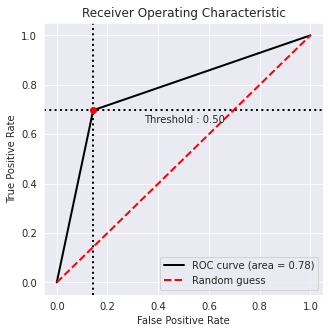

In [9]:
from sklearn.metrics import roc_curve
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(test_y, predsTest, labels=["Class 1", "Class 2"])
print(bc)
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [10]:
x_df = pd.DataFrame(ytr.detach().to("cpu").numpy())
print(x_df.shape)
x_df.to_csv(f"{data_path}/featureSemBertBiLSTMTrain25_1.csv")
x1_df = pd.DataFrame(yva.detach().to("cpu").numpy())
x1_df.to_csv(f"{data_path}/featureSemBertBiLSTMValid25_1.csv")
x2_df = pd.DataFrame(yte.detach().to("cpu").numpy())
x2_df.to_csv(f"{data_path}/featureSemBertBiLSTMTest25_1.csv")

x_df = pd.DataFrame(train_y.detach().to("cpu").numpy())
x_df.to_csv(f"{data_path}/classTrainSemBertBi25_1.csv")
x1_df = pd.DataFrame(val_y.detach().to("cpu").numpy())
x1_df.to_csv(f"{data_path}/classValidSemBertBi25_1.csv")
x2_df = pd.DataFrame(test_y.detach().to("cpu").numpy())
x2_df.to_csv(f"{data_path}/classTesSemBertBi25_1.csv")

(5375, 2)
